# Data Pre-processing

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
# Read in data
df = pd.read_csv('results.txt', sep=",", header=None)
df.columns = ["id", "idx", "filename", "label", "time"]
df.head()

,id,idx,filename,label,time
0,42,1,1_1_2_20161219161757030.jpg.chip.jpg,Not smiling,1.4754
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440


### Filter data

In [3]:
# Create mask to filter away low and high reaction times
time_mask = (df['time'] > 0.2) & (df['time'] < 2)

# Filter out data
df = df[time_mask]

### Get normalized reaction times

In [4]:
# Create a new column with normalized times
scaler = MinMaxScaler()
for id_ in df['id'].unique():
    mask_ = df['id'] == id_
    scaler.fit(df.loc[mask_, ['time']])
    df.loc[mask_, 'time_norm'] = scaler.transform(df.loc[mask_, ['time']])
df.head()

,id,idx,filename,label,time,time_norm
0,42,1,1_1_2_20161219161757030.jpg.chip.jpg,Not smiling,1.4754,1.000000
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943,0.502781
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393,0.199025
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319,0.278258
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440,0.203046


### Create the continuous index

In [24]:
# Define the scale (-scaling to scaling)
scaling = 300

# Create a mask for smile labels
smile_mask = df['label'] == 'Smiling'

# Create continuous index
df.loc[~smile_mask, 'cidx'] = (1 - df.loc[~smile_mask, 'time_norm']) * scaling
df.loc[smile_mask, 'cidx'] = (df.loc[smile_mask, 'time_norm'] - 1) * scaling

,id,idx,filename,label,time,time_norm,cidx
0,42,1,1_1_2_20161219161757030.jpg.chip.jpg,Not smiling,1.4754,1.000000,0.000000
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943,0.502781,149.165740
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393,0.199025,240.292633
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319,0.278258,216.522632
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440,0.203046,239.086164


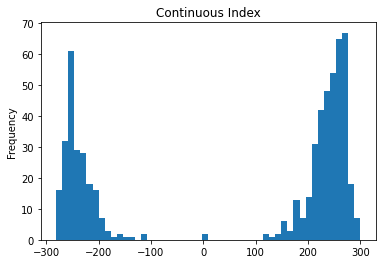

In [39]:
df['cidx'].plot(kind='hist', bins=50, title="Continuous Index", xlabel='s')
df.head()